In [250]:
from datetime import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import requests

In [251]:
def differentiator(array):
    diff_array = []
    for i in range(0, len(array)-1):
        diff_array.append(array[i+1] - array[i])
    return diff_array

In [252]:
def phase_plot(phase_num, start_day, num_days, beta, drift, one_by_epsilon, gamma, rho, original_cases_list, previous, detected):
    # reach = 0.00001 # 0
    if (rho==0):
        rho = 0.00001
    population = 140 * (10**7)
    N = rho * population

    total_infections = []

    S = np.zeros(num_days)
    U = np.zeros(num_days)
    T = np.zeros(num_days)
    Ru = np.zeros(num_days)
    Rt = np.zeros(num_days)
    
    # bias = 1
    T[0] = detected / N
    U[0] = 4 * T[0]
    Ru[0] = Ru[-1]
    Rt[0] = Rt[-1]
    S[0] = 1 - T[0] - U[0] - Rt[0] - Ru[0]

    for i in range(0, num_days-1):
        S[i+1] = S[i] - beta * S[i] * U[i]
        U[i+1] = U[i] + (1 - (1/one_by_epsilon)) * beta * S[i] * U[i] - gamma * U[i]
        T[i+1] = T[i] + (1/one_by_epsilon) * beta * S[i] * U[i] - gamma * T[i]
        Ru[i+1] = Ru[i] + gamma * U[i]
        Rt[i+1] = Rt[i] + gamma * T[i]

    S = S * N
    U = U * N
    T = T * N
    Ru = Ru * N
    Rt = Rt * N

    total_infections += (T + Rt).tolist()

    plt.plot(S)
    plt.plot(U)
    plt.plot(T)
    plt.plot(Ru)
    plt.plot(Rt)
    plt.rcParams["figure.figsize"] = (8, 4.5)

    predicted = differentiator(total_infections)
    predicted = predicted + np.ones(num_days-1) * (1-drift)*previous
    plt.clf()
    plt.plot(predicted)
    plt.title('Phase '+str(phase_num))
    plt.plot(original_cases_list[start_day:start_day+num_days])
    plt.savefig('Phase '+str(phase_num)+'.png')

    return (predicted[-1], T[-1])


In [253]:
print('Beginning file download with requests')

url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
r = requests.get(url)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

with open('owid-covid-data.csv', 'wb') as f:
    f.write(r.content)

Beginning file download with requests
200
text/csv; charset=UTF-8
UTF-8


In [254]:
columns_needed = ['location', 'date', 'total_cases', 'new_cases']
covid_data = pd.read_csv("owid-covid-data.csv", parse_dates = ['date'], dayfirst = True, usecols=columns_needed)
india_data = covid_data[covid_data.location == 'India'].reset_index(drop=True)
dates_list = india_data['date'].tolist()
original_cases_list = india_data['new_cases'].tolist()

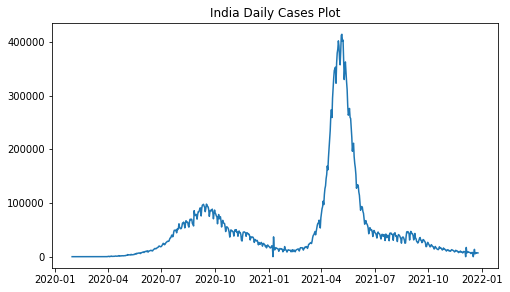

In [255]:
plt.plot(dates_list, original_cases_list)
plt.title("India Daily Cases Plot")
plt.rcParams["figure.figsize"] = (8, 4.5)

In [256]:
fixed_gamma = 0.1
params = [['02-03-2020', 5, 0.33, 0.002, 37, 0],\
          ['20-03-2020', 0, 0.26, 0.0063, 37, 0.1],\
          ['24-04-2020', 5, 0.16, 0.0041, 37, 4],\
          ['21-06-2020', 30, 0.16, 0.0019, 37, 22.4],\
          ['22-08-2020', 10, 0.15, 0.0012, 37, 45.2],\
          ['02-11-2020', 10, 0.21, 0.0011, 37, 44.3],\
          ['01-01-2021', 10, 0.22, 0.0009, 37, 44.5],\
          ['10-02-2021', 40, 0.39, 0.0008, 37, 54.2],\
          ['29-03-2021', 26, 0.33, 0.0011, 37, 85.3]]

0.8526931670962155 86.0
265.63184062004524 1753.0
-432.49506141283905 14933.0
19206.615775125785 61408.0
-149772.98797769088 46253.0
1677989.105609675 18177.0
-15075714.896902192 9309.0
611423202.5927668 53480.0
-15168565702.50282 165553.0


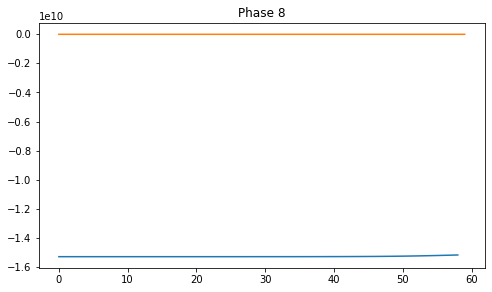

In [257]:
previous = 0
detected = 1

for i in range(len(params)):
    start_date = datetime.strptime(params[i][0], '%d-%m-%Y')
    start_day = dates_list.index(start_date)

    if (i!=len(params)-1):
        end_date = datetime.strptime(params[i+1][0], '%d-%m-%Y')
        num_days = (end_date - start_date).days
    else:
        num_days = 60 
    
    drift = params[i][1]
    beta = params[i][2]
    one_by_epsilon = params[i][4]
    rho = params[i][5]
    
    # phase_num, start_day, num_days, beta, drift, one_by_epsilon, gamma, rho, original_cases_list, previous, detected
    previous, detected = phase_plot(i, start_day, num_days, beta, drift, one_by_epsilon, fixed_gamma, rho, original_cases_list, previous, detected)
    print (previous, detected)
